In [1]:
import pandas as pd
import featuretools as ft
from featuretools.primitives import (
    Month, Year,
    Lag, RollingMean,
    TimeSincePrevious, TimeSince, Diff,
    Mean, Median, Std, Max, Min,
    PercentTrue, Any, All,
    NUniqueDays, NumConsecutiveGreaterMean
)
import joblib

# 📥 1. Cargar dataset
df = pd.read_csv("finalitoul_filtrado.csv")
df['periodo'] = pd.to_datetime(df['periodo'])

# 🧪 2. Sample estratificado (5% por mes)
df_sample = df.groupby("periodo").apply(
    lambda x: x.sample(frac=0.05, random_state=42)
).reset_index(drop=True)

print("✅ Sample creado con shape:", df_sample.shape)

# 🏗 3. Crear EntitySet
es = ft.EntitySet(id="ventas_sampled")

es = es.add_dataframe(
    dataframe_name="ventas",
    dataframe=df_sample,
    index="venta_id",
    make_index=True,
    time_index="periodo"
)

# 🔗 4. Normalizar entidades
es = es.normalize_dataframe("ventas", "clientes", index="customer_id")
es = es.normalize_dataframe("ventas", "productos", index="product_id")

# 🧠 5. Definir primitivas
transform_primitives = [
    Month(), Year(),
    Lag(), RollingMean(),
    TimeSincePrevious(), TimeSince(), Diff()
]

aggregation_primitives = [
    Mean(), Median(), Std(), Max(), Min(),
    PercentTrue(), Any(), All(),
    NUniqueDays(), NumConsecutiveGreaterMean()
]

# ⚙️ 6. Aplicar DFS con máximo de 35 features
feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_dataframe_name="ventas",
    trans_primitives=transform_primitives,
    agg_primitives=aggregation_primitives,
    max_depth=2,
    max_features=35,
    verbose=True
)

# 🧼 7. Agregar lags y delta de 'tn'
for i in range(1, 6):
    feature_matrix[f"tn_lag_{i}"] = df_sample['tn'].shift(i)

feature_matrix["tn_delta"] = df_sample['tn'].diff()

# 💾 8. Exportar feature matrix
feature_matrix.to_csv("features_sample_5porciento.csv", index=False)
joblib.dump(feature_defs, "feature_defs_sample.pkl")

print("📁 Features exportadas como features_sample_5porciento.csv")
print("💾 Definiciones guardadas como feature_defs_sample.pkl")

# 📘 9. Exportar descripción de features
feature_descriptions = []

for feat in feature_defs[:35]:
    description = {
        "feature_name": str(feat.get_name()),
        "feature_type": type(feat).__name__,
        "description": feat.__repr__().replace("\n", " ")
    }
    feature_descriptions.append(description)

# Agregamos también las lags y delta
for i in range(1, 6):
    feature_descriptions.append({
        "feature_name": f"tn_lag_{i}",
        "feature_type": "LagManual",
        "description": f"Lag {i} de la variable tn"
    })

feature_descriptions.append({
    "feature_name": "tn_delta",
    "feature_type": "DiffManual",
    "description": "Diferencia entre tn actual y anterior"
})

df_desc = pd.DataFrame(feature_descriptions)
df_desc.to_excel("descripcion_features.xlsx", index=False)

print("📘 Descripción de features exportada como descripcion_features.xlsx")


c:\Users\waldo\miniconda3\envs\featuretools_env\Lib\site-packages\woodwork\__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
C:\Users\waldo\AppData\Local\Temp\ipykernel_12336\1386622656.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df.groupby("periodo").apply(


✅ Sample creado con shape: (473040, 13)


c:\Users\waldo\miniconda3\envs\featuretools_env\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
c:\Users\waldo\miniconda3\envs\featuretools_env\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
c:\Users\waldo\miniconda3\envs\featuretools_env\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
c:\Users\waldo\miniconda3\envs\featuretools_env\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWa

Built 35 features
Elapsed: 05:18 | Progress: 100%|██████████
📁 Features exportadas como features_sample_5porciento.csv
💾 Definiciones guardadas como feature_defs_sample.pkl
📘 Descripción de features exportada como descripcion_features.xlsx


🌟 MAE (top 20):  0.0010
🌟 RMSE:         0.0661
🌟 R²:           0.9988


C:\Users\waldo\AppData\Local\Temp\ipykernel_12336\2134598708.py:48: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\waldo\miniconda3\envs\featuretools_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


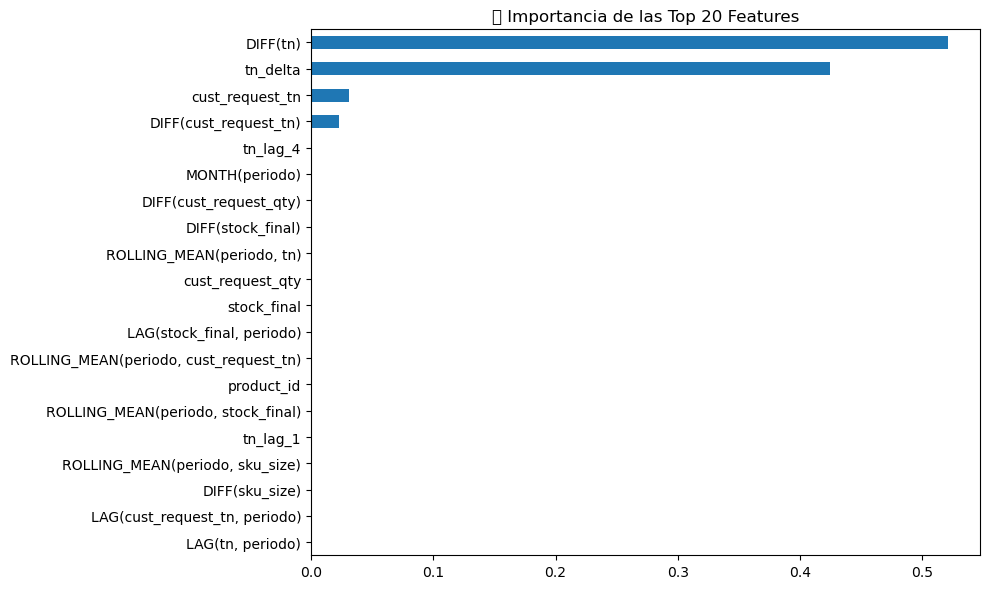

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 📥 1. Cargar dataset
df = pd.read_csv("features_sample_5porciento.csv", index_col=0)
y = df["tn"]
X = df.drop(columns=["tn"]).select_dtypes(include=[np.number]).fillna(0)

# 🧪 2. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 🌲 3. Modelo completo para obtener importancias
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

importances = pd.Series(model.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(20).index.tolist()

# 📉 4. Reentrenar solo con top features
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

model_top = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model_top.fit(X_train_top, y_train)

y_pred_top = model_top.predict(X_test_top)

# 📊 5. Métricas
mae = mean_absolute_error(y_test, y_pred_top)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_top))
r2 = r2_score(y_test, y_pred_top)

print(f"🌟 MAE (top 20):  {mae:.4f}")
print(f"🌟 RMSE:         {rmse:.4f}")
print(f"🌟 R²:           {r2:.4f}")

# 📊 6. Gráfico
top_importances = pd.Series(model_top.feature_importances_, index=top_features)
plt.figure(figsize=(10, 6))
top_importances.sort_values().plot(kind="barh")
plt.title("🎯 Importancia de las Top 20 Features")
plt.tight_layout()
plt.show()


In [24]:
# 📥 Cargar el dataset original
df_orig = pd.read_csv("finalitoul_filtrado.csv")
original_columns = set(df_orig.columns)

# 📥 Cargar el dataset con features generadas
df_features = pd.read_csv("features_sample_5porciento.csv")
final_columns = set(df_features.columns)

# 💡 Separar columnas originales y nuevas
kept_columns = original_columns.intersection(final_columns)
removed_columns = original_columns - final_columns
added_columns = final_columns - original_columns

print("✅ Columnas originales mantenidas:")
print(sorted(kept_columns))

print("\n❌ Columnas originales que ya no están:")
print(sorted(removed_columns))

print("\n🆕 Columnas nuevas generadas:")
print(sorted(added_columns))


✅ Columnas originales mantenidas:
['brand', 'cat1', 'cat2', 'cat3', 'cust_request_qty', 'cust_request_tn', 'customer_id', 'plan_precios_cuidados', 'product_id', 'sku_size', 'stock_final', 'tn']

❌ Columnas originales que ya no están:
['periodo']

🆕 Columnas nuevas generadas:
['DIFF(cust_request_qty)', 'DIFF(cust_request_tn)', 'DIFF(plan_precios_cuidados)', 'DIFF(sku_size)', 'DIFF(stock_final)', 'DIFF(tn)', 'LAG(brand, periodo)', 'LAG(cat1, periodo)', 'LAG(cat2, periodo)', 'LAG(cat3, periodo)', 'LAG(cust_request_qty, periodo)', 'LAG(cust_request_tn, periodo)', 'LAG(plan_precios_cuidados, periodo)', 'LAG(sku_size, periodo)', 'LAG(stock_final, periodo)', 'LAG(tn, periodo)', 'MONTH(periodo)', 'ROLLING_MEAN(periodo, cust_request_qty)', 'ROLLING_MEAN(periodo, cust_request_tn)', 'ROLLING_MEAN(periodo, plan_precios_cuidados)', 'ROLLING_MEAN(periodo, sku_size)', 'ROLLING_MEAN(periodo, stock_final)', 'ROLLING_MEAN(periodo, tn)', 'tn_delta', 'tn_lag_1', 'tn_lag_2', 'tn_lag_3', 'tn_lag_4', 'tn_lag

OJO!! Acá deberían seguir líneas de código que concatenan las features del sample5% con el dataset original. Al construir el dataset final dataset_completo_con_features.csv, se usó un código que se borró. Pero en definitiva, esto fue parte del proceso para construir el dataset con el que se trabaja